## Goals

Prepare for Neural Nets from scratch by estimating a generalized linear model via gradient descent (from scracth). 

We'll (briefly) cover 
* Working with matrices and n dimensional arrays in numpy.
* Solving the least squares problem directly (via normal equations) and indirectly (via gradient descent)
* Estimating logistic regression via gradient descent
* Estimating logistic regression via stochastic gradient descent (time permitting)

## Prerequisites

Assumed knowledge of the following

* Matrix algebra
* Multivariate calculus

The bare minimum is matrix algebra

## Working with matrices in numpy

The classes that represent matrices, and basic operations such as matrix multiplications and transpose are a part of numpy. 

`numpy.matrix` is matrix class that has a more convenient interface than `numpy.ndarray` for matrix operations. This class has matrix multiplication as default for the * operator, and contains `I` and `T` members that serve as shortcuts for inverse and transpose.  

Despite its convenience, the use of the `numpy.matrix` class is discouraged, since it adds nothing that cannot be accomplished with 2D `numpy.ndarray` objects, and may lead to a confusion of which class is being used.  With that being said, we will use the `numpy.matrix` class for this notebook.  

## scipy.linalg vs numpy.linalg

`scipy.linalg` contains all the functions in `numpy.linalg`. plus some other more advanced ones not contained in `numpy.linalg`

Another advantage of using `scipy.linalg` over `numpy.linalg` is that it is always compiled with BLAS/LAPACK support, while for numpy this is optional. Therefore, the scipy version might be faster depending on how numpy was installed.

Therefore, unless you don’t want to add scipy as a dependency to your `numpy` program, use `scipy.linalg` instead of `numpy.linalg`.  That being said, we will use `numpy.linalg` for this notebook

For our purposes we will work with matrices.  Feel free to convert this notebook to ndarrays.  

Below we'll demonstrate how to do some important operations necessary for regression from scracth

## Creating a matrix

In [6]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from scipy.linalg import expm

import seaborn as sns
%matplotlib inline
x = np.matrix([[2,7,6],[9,5,1],[4,3,8]])
print(x)
# or
print("\nlike matlab")
x = np.matrix("[2 7 6; 9 5 1; 4 3 8]")
print(x)
x_ndarray = np.array([[2,7,6],[9,5,1],[4,3,8]])
print("\nn-d array")
print(x_ndarray)

[[2 7 6]
 [9 5 1]
 [4 3 8]]

like matlab
[[2 7 6]
 [9 5 1]
 [4 3 8]]

n-d array
[[2 7 6]
 [9 5 1]
 [4 3 8]]


We'll only highlight operations on matrices and ndarrays when worth noting.

### Transpose of a Matrix

Very fundamental operation is transposition.  We obtain this in numpy with 

In [10]:
print(x.T)

[[2 9 4]
 [7 5 3]
 [6 1 8]]


### Determinants

There are two straight forward options for calculating determinants. `scipy.linalg.det` or `numpy.linalg.slogdet`

`scipy.linalg.det` returns the determinant, while `numpy.linalg.slogdet` returns the sign and natural logrithm of a determinant.  If an array has a very small or very large determinant, then a call to `det` may overflow or underflow.  `numpy` signed log determinant (slog) is more robust against such issues, because it computes the logarithm of the determinant rather than the determinant itself.

Check out Linear Algebra Done Right for a determinant free treatment of linear algebra.  It is awesome.  

In [11]:
slogdet = np.linalg.slogdet(x)
print(slogdet[0]*np.exp(slogdet[1]))
print(np.linalg.det(x))

-360.0
-360.0


### Slicing 

Very often we'll be interesting in a particular row or column or sub-matrix of a matrix.  We'll refer to the operations of obtaining these objects as slicing.

In [16]:
# slicing
# first row
print("slicing a matrix\n")
print(x[0,:])
print("\nshape of x[0,:] is {}".format( x[0,:].shape))
print("\nvs slicing an ndarray\n")
print(x_ndarray[0,:])
print("\nshape of x_ndarray[0:] is {}".format(x_ndarray[0,:].shape))

slicing a matrix

[[2 7 6]]

shape of x[0,:] is (1, 3)

vs slicing an ndarray

[2 7 6]

shape of x_ndarray[0:] is (3,)


In [17]:
# slicing
# first column
print("slicing a matrix\n")
print(x[:,0])
print("\nshape of x[:,0] is {}".format( x[0,:].shape))
print("\nvs slicing an ndarray\n")
print(x_ndarray[:,0])
print("\nshape of x_ndarray[:,0] is {}".format(x_ndarray[0,:].shape))

slicing a matrix

[[2]
 [9]
 [4]]

shape of x[:,0] is (1, 3)

vs slicing an ndarray

[2 9 4]

shape of x_ndarray[:,0] is (3,)


In [21]:
# slicing 
# top 2x2 matrix
print(x[0:2,0:2])


[[2 7]
 [9 5]]


### Dot Products and Matrix Multiplication

Given two vectors $x,y$ in $\mathbb{R}^n$, the dot product (or inner product) of $x$ and $y$, written $x\cdot y$ or sometimes $\left<x,y\right>$ is defined as 
$$\left<x,y\right> = \sum_{i=1}^n x_i y_i$$

If $A$ is $m \times n$ and $B$ is $n \times p$, then the product $C = AB$ is $m \times p$ and the 

$i,j$ element of $C$ is defined as 

$$C_{i,j} = A_{i,:} \cdot B_{:,j} = \sum_{k=1}^n A_{i,k}B_{k,j}$$

Or we could say that the $i,j$ element of $C$ is the dot product of the $i^{th}$ row of $A$ and the $j^{th}$ column of $B$. 

The norm of a vector is $\sqrt{\left<x,x\right>}$ or more commonly, $\|x\|$.  For any two vectors $x,y \in \mathbb{R}$, we have 

$$\cos(\theta) = \frac{x\cdot y}{\|x\|\|y\|}$$

where $\theta$ is the angle between $x$ and $y$.  We may write vectors in n dimension space with boldface type and write matrices in italics when clarification is require.  

In [9]:
# dot products
z = np.array([1,2,3])
z.dot(z)

14

In [25]:
# matrix multiply
print(x * x)

# same as 
y = np.zeros([3,3])
for i in range(3):
    for j in range(3):
        y[i][j] = x[i,:].dot(x[:,j])
print()
print(y)

[[91 67 67]
 [67 91 67]
 [67 67 91]]

[[ 91.  67.  67.]
 [ 67.  91.  67.]
 [ 67.  67.  91.]]


### Hadamard Product

For two matrices $A$ and $B$ the Hadamard Product, written as $A \odot B$ is element wise multiplicate, thus $\dim(A)$ must equal $\dim(B)$

In [26]:
# hadamard product -- element-wise multiplication
print(np.multiply(x,x))

[[ 4 49 36]
 [81 25  1]
 [16  9 64]]


### Identify Matrices and Matrix Inversion

Not going to get into definitions 

In [12]:
# identity matrix
I = np.eye(3)
print(x * I)
print()
print(I * x)

[[ 2.  7.  6.]
 [ 9.  5.  1.]
 [ 4.  3.  8.]]

[[ 2.  7.  6.]
 [ 9.  5.  1.]
 [ 4.  3.  8.]]


In [4]:
# inverting a square matrix
print(np.linalg.inv(x))
print()
print( np.round(x*np.linalg.inv(x),2))

[[-0.10277778  0.10555556  0.06388889]
 [ 0.18888889  0.02222222 -0.14444444]
 [-0.01944444 -0.06111111  0.14722222]]

[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0.  0.  1.]]


In [5]:
# "inverting" a non-square matrix
x1 = np.concatenate( (x, np.matrix([10,12,11])), axis=0)
pinv = np.linalg.pinv(x1)
print("x1")
print(x1)
print("\npseudo inverse of x1")
print(pinv)
print("\npinv*x1")
print(np.round(pinv*x1,1))

x1
[[ 2  7  6]
 [ 9  5  1]
 [ 4  3  8]
 [10 12 11]]

pseudo inverse of x1
[[-0.10158658  0.10631095  0.06449901 -0.00116214]
 [ 0.13958365 -0.00904452 -0.16969835  0.04810267]
 [-0.02602193 -0.0652822   0.14385327  0.00641706]]

pinv*x1
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0. -0.  1.]]


### Other useful operations

In [15]:
# multiplication by scalar
p = 1/15 * x
p

matrix([[ 0.13333333,  0.46666667,  0.4       ],
        [ 0.6       ,  0.33333333,  0.06666667],
        [ 0.26666667,  0.2       ,  0.53333333]])

In [16]:
# sum columns
print( p.sum(axis=0))
print()
# sum rows 
print( p.sum(axis=1))

[[ 1.  1.  1.]]

[[ 1.]
 [ 1.]
 [ 1.]]


In [17]:
# mean and standard deviation of columns
print( x.mean(axis=0), x.std(axis=0))
# mean of rows - just set axis=1


[[ 5.  5.  5.]] [[ 2.94392029  1.63299316  2.94392029]]


In [18]:
## numpy funtions act element-wise on matrices and arrays
np.exp(p)

matrix([[ 1.14263081,  1.59466976,  1.4918247 ],
        [ 1.8221188 ,  1.39561243,  1.06893911],
        [ 1.30560517,  1.22140276,  1.70460487]])

In [19]:
## for functions of matrices look into scipy.linalg, e.g., exponetial of matrix
print(expm(p))

[[ 1.40505877  0.69054062  0.62268243]
 [ 0.826257    1.60863334  0.28339149]
 [ 0.48696606  0.41910787  1.81220791]]


In [22]:
# Taylor Approx of exp(p)
def fact(n):
    if n == 1:
        return n
    else:
        return n*fact(n-1)

#np.eye(3) + p + 1/2*p*p + 1/6*p*p*p + 1/24*p*p*p*p + 1/120*p*p*p*p*p
e = np.eye(3)
for i in range(1,10):
    e += 1/fact(i)*np.linalg.matrix_power(p,i)
print(e)

[[ 1.40505867  0.69054052  0.62268233]
 [ 0.8262569   1.60863324  0.28339139]
 [ 0.48696595  0.41910777  1.81220781]]


In [23]:
# matrix of ones
bias = np.matrix(np.ones([3,1]))
# joining the matrix of ones with our matrix x1 from above
x2 = np.concatenate( [bias, x],axis=1)
print(x2)
print()
# to append the bias as a row, we'll do the following
x3 = np.concatenate( [x2, np.ones([1,4])],axis=0)
print(x3)

[[ 1.  2.  7.  6.]
 [ 1.  9.  5.  1.]
 [ 1.  4.  3.  8.]]

[[ 1.  2.  7.  6.]
 [ 1.  9.  5.  1.]
 [ 1.  4.  3.  8.]
 [ 1.  1.  1.  1.]]


Demonstrate similar operations on nd arrays


In [25]:
x = np.array([[2,7,6],[9,5,1],[4,3,8]])

print("Hadamard product")
print(x*x) # if x were a matrix, this would be matrix mulitply
print("matrix multiply")
print( np.dot(x,x))

print( np.dot(x.T,x))

Hadamard product
[[ 4 49 36]
 [81 25  1]
 [16  9 64]]
matrix multiply
[[91 67 67]
 [67 91 67]
 [67 67 91]]
[[101  71  53]
 [ 71  83  71]
 [ 53  71 101]]


In [26]:
x2.mean(axis=0)

matrix([[ 1.,  5.,  5.,  5.]])

In [28]:
np.multiply(x2.mean(axis=0),np.ones([3,4]))

matrix([[ 1.,  5.,  5.,  5.],
        [ 1.,  5.,  5.,  5.],
        [ 1.,  5.,  5.,  5.]])

In [29]:
## calc covariance and correlation matrix

z = np.matrix(x2 - np.multiply(x2.mean(axis=0),np.ones([3,4])))
sig = np.sqrt(np.diag(np.diag(z.T*z)))


print("covariance matrix")
print(z.T*z / 2)
print()
print("correlation matrix")
print(linalg.pinv(sig)*(z.T*z)*np.linalg.pinv(sig))
## since the generalized inverse was used the first row and column are 0 instead of nan

covariance matrix
[[  0.   0.   0.   0.]
 [  0.  13.  -2. -11.]
 [  0.  -2.   4.  -2.]
 [  0. -11.  -2.  13.]]

correlation matrix
[[ 0.          0.          0.          0.        ]
 [ 0.          1.         -0.2773501  -0.84615385]
 [ 0.         -0.2773501   1.         -0.2773501 ]
 [ 0.         -0.84615385 -0.2773501   1.        ]]


## Generating Data

In [30]:
## useful function from statsmodels
from statsmodels.api import add_constant
## add_constant will check the rank of your matrix prior to adding a column on 1s.

n=500

X = np.random.randn(n,2)
c = np.matrix(np.ones([n,1]))
y = (X*X).sum(axis=1)

noise = np.random.lognormal(-1,1,n)

y = 1*( (y + noise ) > 2)
y = np.matrix(y).T

/home/tim/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [31]:
column_names = ['y']
column_names.extend( ['x{}'.format(i) for i in range(X.shape[1])])
data = DataFrame(np.concatenate( [y.reshape(n,1), X], axis=1), 
                 columns = column_names )
data.describe()

,y,x0,x1
count,500.000000,500.000000,500.000000
mean,0.482000,-0.019947,-0.033874
std,0.500176,0.971625,0.956510
min,0.000000,-2.675461,-2.761149
25%,0.000000,-0.732427,-0.672921
50%,0.000000,-0.071604,-0.010335
75%,1.000000,0.718496,0.569781
max,1.000000,3.439795,3.054099


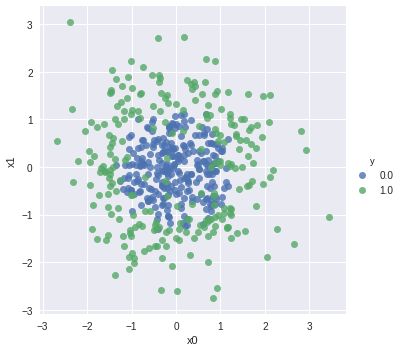

In [32]:
plot=sns.lmplot('x0','x1',data,hue='y', fit_reg=False)

In [33]:
# add bias into X
X = np.concatenate( (c,X), axis=1)

## Fitting a Linear Regression

Fitting a linear regression is a fairly simply procedure, but can be prove difficult if there are a significant number of observations, or if there are more features than observations.  

If we suppose that our target variable $y$ can be written as a linear combination of features $X_1, X_2, \ldots, X_n$, i.e., 

$$y = a + b_1X_1 + b_2X_2 + \cdots + b_nX_n + \epsilon$$

We can write the succinctly in matrix form as 

$$y = X\beta + \epsilon$$

Our objective now is to attempt to provide the single "best" estimate of the weights.  This is known as point estimation.  We easily justified method to select "best" estimates is be minimizing the average squared distance between the linear projection of our feature matrix and the target.  

$$C(\beta) = \frac{1}{N}\sum_{i=1}^N (y_i - X_i\beta)^2$$

Here $i$ is used to index the rows of the matrix.  The object above is referred to as the mean square error.  

We may write it in matrix form as 

$$ C(\beta) = \frac{1}{N} (y - X\beta)^T(y - X\beta)$$

Therefore, we can do some calculus to find the "best" estimate of the weights.  

$$ \frac{\partial}{\partial \beta} C(\beta) = -\frac{1}{N}X^T(y - X\beta)$$

Setting this equal to 0 and solving for $\beta$ yields the normal equations.  

$$ \beta^* = (X^TX)^{-1}X^Ty $$

Notice how we wrote $\beta^*$ instead of $\beta$.  From the frequentist perspective $\beta$ is a fixed value, and what we wrote above is a point estimate of $\beta$, which is a function of random variables, $\beta$ itself is a random variable, so we will write $\beta^*$ instead.  

In [34]:
## solution to the least squares problem
print(np.linalg.inv(X.T*X)*X.T*y)

[[ 0.48220298]
 [-0.00085815]
 [ 0.00649749]]


In [35]:
## solution to least squares problem via pseudo inverse
print(np.linalg.pinv(X)*y)

[[ 0.48220298]
 [-0.00085815]
 [ 0.00649749]]


#### More variables than observations? 

One popular method to handle this is via ridge regression.  Starting with 

$$C(\beta) = (y - x\beta)^T(y-x\beta)$$

We add some penality, which is a function of $\beta$ as well.  The penalty will be used to keep the model from saturating.  A penalty which lends itself well to this problem is the $L^2$ norm.   

$$C^*(\beta) = \frac{1}{2} C(\beta) + \frac{\lambda}{2} \|\beta\|$$

There is a closed form solution to this problem.  

$$\frac{\partial C^*}{\partial \beta} = -x^T(y-x\beta) + \lambda \beta$$

Setting this derivative equal to 0, we get 

$$0 = -x^Ty + x^Tx\beta + \lambda \beta = -x^Ty + (x^Tx + \lambda I)\beta$$

Thus 

$$\hat{\beta} = (x^Tx + \lambda I)^{-1} x^Ty$$

Basically, we add a small amount to the diagonal of covariance matrix of $x$ to insure invertibility so that the solution exists.  

## Optimization

Now, this is a fairly simply problem, but let's solve it using gradient descent.

Gradient descent is a first order optimization method, that is, it only uses first derivatives to solve the optimization problem (i.e., find a local extremum).  

This method is so great because 

* you don't need to work about the hessian of the objective function
* it is very easy to implement
* it is embarrasingly parrallelizable
* its extension, Stochastic Gradient Descent, and Mini Batch Gradient Descent are very popular in deep learning 

### Intuition behind gradient descent

For intuitions sake, lets consider $f: \mathbb{R} \to \mathbb{R}$ which is at least differentiable on its domain. We know that for any $x$ in the domain of $f$, we have 

$$f\big(x - \epsilon \;\text{sign}(f'(x)\big) \le f(x)$$ 

for small enough $\epsilon$.  To see this, suppose that for some $x$ in domain of $f$, and $f'(x) > 0$, then $f$ is increasing at $x$, thus there exists $\epsilon > 0$ such that $f(x - \epsilon) < f(x)$.  On the other hand, if $f'(x) < 0$ then there exists $\epsilon > 0$ such that $f(x + \epsilon) < f(x)$.  Lastly if $f'(x) = 0$, then we are at a (local) optimum.  This means that we can reduce $f$ by moving $x$ by a small amount in the direction opposite the sign of its derivative.  Once $f'(x) = 0$, the derivative provides no information about which direction to move.  

### Extending to several dimensions

Moving to functions of several variables $f: \mathbb{R}^N \to \mathbb{R}$.  We will consider the gradient and the directional derivative.  The directional derivative of a function in the direction $(u_1,u_2)$ is the slope of the function $f$ in the direction $(u_1,u_2)$, usually with $u_1^2 + u_2^2 = 1$

The gradient is an N-tuple of partial derivatives of $f$, written $\nabla f$.  

We will also be interested in the directional derivative.  The directional derivative of $f$ in the direction of $u = (u_1, u_2)$ where $\|u\| = 1$ is 

$$\frac{\partial}{\partial \alpha} f(x_0 + \alpha u_1, y_0 + \alpha u_2)$$

If we write $g(\alpha) = f(x_0 + \alpha u_1, y_0 + \alpha u_2)$, and $x = x_0 + \alpha u_1, y = y_0 + \alpha u_2$

$$g'(\alpha) = \frac{\partial f}{\partial x}\frac{\partial x}{\partial \alpha}
+ \frac{\partial f}{\partial y}\frac{\partial y}{\partial \alpha} = f_x(x,y) u_1 + f_y(x,y) u_2$$

Lastly, 
$$g'(0) = f_x(x_0, y_0) u_1 + f_y(x_0, y_0) u_2 = \nabla f \cdot u,$$

To minimize $f$ we would liek to find the direction in which $f$ decreases fastest, queue the directional derivative, we will minimize 

$$\min_{u, \|u\|=1} \nabla f \cdot u$$

Multiply the top and bottom by $\|u\| \|\nabla f\|$ to get 

$$\min_{u, \|u\|=1}\|u\| \|\nabla f\| \cos(\theta)= \min_{u, \|u\|=1}\|\nabla f\| \cos(\theta)$$

where $\theta$ is the angle between $u$ and the gradient.  The direction is such that $u$ points in the direction opposite of the gradient ( cosine of this angle will be -1)

For the least squares problem described above, our gradient descent algorithm becomes
~~~
grad = -X'*(y - X*beta)
while norm(grad) > 1e-6
  grad = -X'*(y - X*beta)
  beta -= learning_rate * grad / n
~~~
We will set the learning rate to some small amount like 0.1.

In [36]:
## create the objective function 

class MSE(object):
    def valueAt( x, y, beta):
        yhat = x * b
        e = y - yhat
        return y.T*y / x.shape[0]
    def gradientAt(x, y, beta):
        yhat = x * beta
        e = y - yhat
        return -x.T*e / x.shape[0]
  
class L2(object):
    def valueAt(b):
        return 1/2*linalg.norm(b)
    def gradientAt(b):
        return b
        
        
    
class GradientDescent(object):
    def __init__(self, cost_function=MSE, tolerance=1e-6, regularization=None):
        self.cost_function = cost_function
        self.tol = tolerance
        self.iter = 0
        self.beta = None
        self.regularization = regularization
        
    def optimize(self, X,y,learning_rate=0.1,init_params=None):
        if init_params is None:
            beta = np.matrix( np.zeros(X.shape[1])).T
        else:
            beta = init_params
        grad = self.cost_function.gradientAt(X,y,beta)
        if self.regularization is not None:
            pass
        prev_beta = beta
        beta = beta - learning_rate*grad
        ## several termination criteria to use
        ## abs change in beta is small
        ## abs change in object is small
        ## here we use magitute of the gradient
        while np.linalg.norm(prev_beta - beta) > self.tol:
            prev_beta = beta
            self.iter += 1
            grad = self.cost_function.gradientAt(X,y,beta)
            if self.regularization is not None:
                pass
            beta = beta - learning_rate*grad
        self.beta = beta
        return beta

In [37]:
## exercise - how to add regularization into the gradient descent??

In [38]:
b = np.linalg.pinv(X)*y
print(b)

[[ 0.48220298]
 [-0.00085815]
 [ 0.00649749]]


In [39]:

linreg = GradientDescent(MSE, 1e-6)
b = linreg.optimize(X,y)
print(linreg.beta)
print("total number of iterations: {}".format(linreg.iter))

[[ 0.48219576]
 [-0.00086106]
 [ 0.00649237]]
total number of iterations: 106


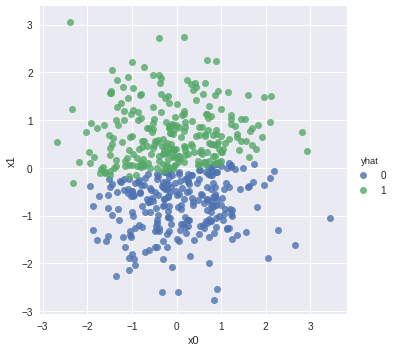

In [40]:
yhat = np.array((X*b > y.mean())*1).ravel()
data["yhat"]= yhat
sns.lmplot("x0","x1",data,hue="yhat", fit_reg=False)

In [41]:
# let's add in the square of each X
X = np.concatenate( (X, np.multiply(X[:,1:],X[:,1:])) ,axis=1)

In [42]:
## gradient descent
gd1 = GradientDescent(MSE)
b = gd1.optimize(X,y)
print(b)
print("total number of iterations: {}".format(gd1.iter))

[[ 0.15759507]
 [-0.00335215]
 [-0.00651864]
 [ 0.1672727 ]
 [ 0.18205865]]
total number of iterations: 173


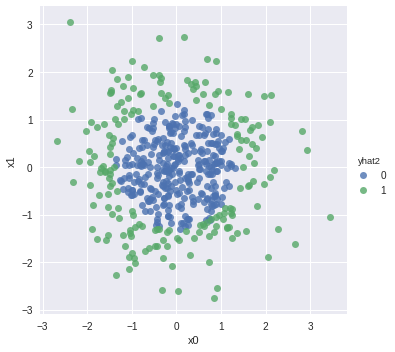

In [43]:
yhat2 = np.array((X*b > y.mean())*1).ravel()
data["yhat2"]= yhat2
sns.lmplot("x0","x1",data,hue="yhat2", fit_reg=False)

In [44]:
TP= (data["yhat"]==1) & (data["y"] == 1)
FP = (data["yhat"]==1)&(data["y"] == 0)
FN = (data["yhat"]==0)&(data["y"] == 1)
TN = (data["yhat"] == 0)&(data["y"] == 0)
cm = np.array( [[TP.sum(), FP.sum()],[FN.sum(), TN.sum()]])

In [45]:
np.diag(cm).sum()

251

## Fitting a Logistic Regression

Given a categorical variable $y$ with 2 classes (binary variable), $y$ can best be described as a Bernoulli random variable - which is a random variable that takes the value $A$ with probability $p$ and the value $B$ with probability $1 - p$.  

We are interested in modeling the posterior probabilities of the 2 classes via some linear function in $x$.  

$y$ can best be described as a Bernoulli random variable, that is a variable that can assume two values

The model takes the form

$$ \log \frac{ \mathbb{P}(y = 1 | X = x) }{ \mathbb{P}(y = 0 | X = x) } = x\beta $$

The function on left hand side is known as the logit function.  

It can be shown then that 
$$ \mathbb{P}(y = 1 | X = x) = \frac{\exp(x\beta)}{(1 + \exp(x\beta)}$$
The function on the right is the sigmoid function and is strictly between 0 and 1.  
and 
$$ \mathbb{P}(y = 0 | X = x) = 1 - \mathbb{P}(y = 1 | X = x)$$ 

We will use objective function 

$$-\sum_{i=1}^N \big(y_i\log(p_i) + (1 - y_i)\log(1 - p_i)\big)$$

Unfortunately, there is not closed form solution to this problem and must be solved numerically.  Standard method use Newton Rhapson (second order method - it uses gradient and Hessian for the optimization), but we will use gradient descent, which is first order since it only uses the gradient.  

In [46]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

## creating this as object to expose value and gradient methods 
class BCE(object):
    
    def valueAt( x, y, beta):
        p = sigmoid(x*beta)
        ll = y.T*(np.log(p + 1e-3)) + (1 - y).T*( np.log(1 - p + 1e-3))
        return -ll / x.shape[0]
        
    def gradientAt( x, y, beta):
        p = sigmoid(x*beta)
        grad = x.T.dot(y - p) / x.shape[0]
        return -grad

In [47]:
logistic_regression = GradientDescent(BCE, tolerance=1e-7)
b = logistic_regression.optimize(X,y,learning_rate=1.0)
print("iterations: {}".format(logistic_regression.iter))
print(logistic_regression.beta.T)
BCE.valueAt(X,y,b)

iterations: 2282
[[-4.77171992  0.28598624  0.18564922  3.19748987  3.47385885]]


matrix([[ 0.25113517]])

In [48]:
import statsmodels.api as sma
import statsmodels as sm
fit = sma.GLM(endog = y, exog=X, family = sm.api.families.Binomial()).fit()
b = fit.params
print(b)
print(BCE.valueAt(X,y,np.matrix(b).T))

[-4.77173343  0.28598727  0.18565042  3.19749936  3.47386902]
[[ 0.25113516]]


As is, the model is a linear classifier, and will not yeild a very good decision boundary.  

In [49]:
y.mean()

0.48199999999999998

In [50]:
data["phat"] = 1*(sigmoid(X.dot(logistic_regression.beta))>0.5)
data.head()

,y,x0,x1,yhat,yhat2,phat
0,0.0,-0.068141,-0.026296,1,0,0
1,1.0,1.364113,-1.394722,0,1,1
2,1.0,2.647434,-1.619933,0,1,1
3,0.0,-0.200194,-0.114280,0,0,0
4,0.0,-0.782122,0.430099,1,0,0


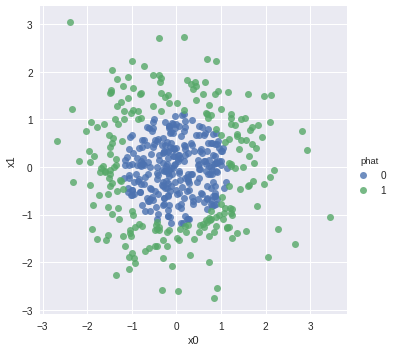

In [51]:
sns.lmplot('x0','x1',data,hue='phat',fit_reg=False)

In [52]:
TP= (data["phat"]==1) & (data["y"] == 1)
FP = (data["phat"]==1)&(data["y"] == 0)
FN = (data["phat"]==0)&(data["y"] == 1)
TN = (data["phat"] == 0)&(data["y"] == 0)
cm = np.array( [[TP.sum(), FP.sum()],[FN.sum(), TN.sum()]])

In [53]:
print(cm)
np.diag(cm).sum()

[[210  16]
 [ 31 243]]


453

## stochastic gradient descent

Stochastic graident descent (SGD) is the defacto method for training neural networks.  It is also used to train large linear models on very large datasets.  

As we have seen with our linear and logistic regression examples above, the cost functions are additive, and the gradient descent algorithm can cost alot in terms of the computations involves.  

Stochastic gradient descent computes the gradient using as few a one example to as many as a few hundred.  This sample is referred to as a minibatch, and we will need to set the minibatch size as an algorithm.  The minibatch of sample is drawn uniformly from the training data.  This implies that a model may be trained on very few number of expamples relative to the entire dataset.  

This algorithm is very useful when data sets are huge, and cannot fit in main memory.  It also easily incorporates new data into the updates of a model.  

On each step of the algorithm, we sample a minibatch of examples from the training data.  The minibatch size typically ranges between 1 and a few hundred.  Small batches can offer regularizing effects, but will also require very small learning rates.  Depending on the way sampling of examples, 

~~~
learning_rate = e
beta = np.random.randn(n,1)
while stopping criterion not met do:
  sample a minibatch of m examples from the training set
  computer gradient estimate g <- 1/m grad( sample ) 
  update beta <- beta - learning_rate*g
~~~

In [54]:
num_features = X.shape[1]
num_outputs = 1
r = np.sqrt(6/(num_features + num_outputs)) ## Glorot and Bengio
beta = np.random.uniform(-r, r,num_features )
beta = np.matrix(beta).T
# mini-batch gradient descent
nobs = X.shape[0]
grad = np.random.randn(X.shape[1])
e0 = 10
etau = 0.01*e0
it = 0
tau = 300

In [55]:
## inital sgd version 
## this is purely random - potential to not see all observations when estimating he model
epochs = 500 #
minibatch_size = 32
it = 0
for i in range(epochs):
    index = np.arange(X.shape[0])
    it += 1
    alpha = it / tau
    learning_rate =  (1 - alpha)*e0 + alpha*etau if it < tau else learning_rate
    batch = np.random.choice(nobs, minibatch_size, replace=False)
    grad = BCE.gradientAt(X[batch, :], y[batch], beta)
    beta = beta - learning_rate*grad
    if it < 10:
        print("cost function at current beta: {}".format(BCE.valueAt(X[batch,:],y[batch],beta)))
print()
print(BCE.valueAt(X,y,beta), linalg.norm(BCE.gradientAt(X,y,beta)))
print()
print(beta)

cost function at current beta: [[ 2.00729218]]
cost function at current beta: [[ 0.62157661]]
cost function at current beta: [[ 0.87887499]]
cost function at current beta: [[ 0.80641547]]
cost function at current beta: [[ 0.27688549]]
cost function at current beta: [[ 0.22992011]]
cost function at current beta: [[ 0.19879817]]
cost function at current beta: [[ 0.362749]]
cost function at current beta: [[ 0.12036996]]

[[ 0.25139122]] 0.00569666948134

[[-4.95284559]
 [ 0.29678186]
 [ 0.21058406]
 [ 3.3901246 ]
 [ 3.61912376]]


In [56]:
# sgd with proper sampling


num_features = X.shape[1]
num_outputs = 1
r = np.sqrt(6/(num_features + num_outputs)) ## Glorot and Bengio
beta = np.random.uniform(-r, r,num_features )
beta = np.matrix(beta).T
epochs = 500
num_batches = 32
it = 0
for i in range(epochs):
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    for i in np.arange( np.ceil(nobs/num_batches)):
        batch = index[:num_batches] if len(index) > num_batches else index.copy()
        index = np.delete(index, np.arange(num_batches)) if len(index) > num_batches else None
        it += 1
        alpha = it / tau
        learning_rate =  (1 - alpha)*e0 + alpha*etau if it < tau else learning_rate
        grad = BCE.gradientAt(X[batch, :], y[batch], beta)
        beta = beta - learning_rate*grad
        if it < 10:
            print("cost function at current beta: {}".format(BCE.valueAt(X[batch,:],y[batch],beta)))
print()
print(BCE.valueAt(X,y,beta), linalg.norm(BCE.gradientAt(X,y,beta)))
print()
print(beta.T)
print(b)
print("iterations {}".format(it))

cost function at current beta: [[ 0.95066849]]
cost function at current beta: [[ 0.66185478]]
cost function at current beta: [[ 1.45946054]]
cost function at current beta: [[ 0.295997]]
cost function at current beta: [[ 0.31540295]]
cost function at current beta: [[ 0.19998914]]
cost function at current beta: [[ 0.12559807]]
cost function at current beta: [[ 0.14735675]]
cost function at current beta: [[ 0.35739555]]

[[ 0.25113226]] 0.000671151121796

[[-4.77913742  0.28799298  0.18814773  3.19671217  3.47740355]]
[-4.77173343  0.28598727  0.18565042  3.19749936  3.47386902]
iterations 8000


#### AdaGrad (adaptive gradient) 

This algorithm inidividually adapts the learning rate of all model parameters.  

In [81]:
## sgd with adagrad

num_features = X.shape[1]
num_outputs = 1
u = np.sqrt(6/(num_features + num_outputs)) ## Glorot and Bengio
beta = np.random.uniform(-u, u,num_features )
beta = np.matrix(beta).T
epochs = 100
num_batches = 32
it = 0
############# specific to adagrad ##########
epsilon = 1e-7
delta = 1e-7
r = np.matrix( np.zeros([X.shape[1],1]))
############################################

In [82]:
c = []
for i in range(epochs):
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    for i in np.arange( np.ceil(nobs/num_batches)):
        it += 1
        batch = index[:num_batches] if len(index) > num_batches else index.copy()
        index = np.delete(index, np.arange(num_batches)) if len(index) > num_batches else None
        grad = BCE.gradientAt(X[batch, :], y[batch], beta)
        r = r + np.multiply(grad, grad)
        update = np.multiply(epsilon / (delta + r) , grad)
        beta = beta - learning_rate*grad
        c.append(BCE.valueAt(X,y,beta)[0,0])
        if it < 10:
            print("cost function at current beta: {}".format(BCE.valueAt(X,y,beta)))
print()
print(BCE.valueAt(X,y,beta), linalg.norm(BCE.gradientAt(X,y,beta)))
print()
print(beta.T)
print(b)
print("iterations {}".format(it))

cost function at current beta: [[ 0.64925267]]
cost function at current beta: [[ 0.63377827]]
cost function at current beta: [[ 0.60348077]]
cost function at current beta: [[ 0.59648101]]
cost function at current beta: [[ 0.59396169]]
cost function at current beta: [[ 0.57471379]]
cost function at current beta: [[ 0.56391961]]
cost function at current beta: [[ 0.55632568]]
cost function at current beta: [[ 0.5463211]]

[[ 0.25370042]] 0.0056809439007

[[-4.14124935  0.24387633  0.13589159  2.76321422  3.01394292]]
[-4.77173343  0.28598727  0.18565042  3.19749936  3.47386902]
iterations 1600
